![](FBS-with-Trendlines.png)

### The trendlines are polynomials of degree 1 (linear), 2, 3, 4. Which trendline is the best fit?

In [97]:
import numpy as np
import pandas as pd
from pandas import DataFrame as DF, Series as Ser
from matplotlib import pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline


In [98]:
# If you're running the version downloaded from GitHub, uncomment the next line
# after this comment and comment out the line following; else do the opposite.
#path =! echo `pwd`/"all-day-glucose-20240225.xlsx"
path = "all-day-glucose.xlsx"
print(path)
df0 = pd.read_excel(path).iloc[:, :18]
columns = df0.iloc[0, 0:18]
df0.columns = columns
pd.set_option('display.max_rows', 4)
df0

all-day-glucose.xlsx


,Date,FBS,8 AM,9 AM,10 AM,11 AM,12 PM,1 PM,2 PM,3 PM,4 PM,5 PM,6 PM,7 PM,8 PM,9 PM,10 PM,Average by Date
0,Date,FBS,8 AM,9 AM,10 AM,11 AM,12 PM,1 PM,2 PM,3 PM,4 PM,5 PM,6 PM,7 PM,8 PM,9 PM,10 PM,Average by Date
1,2023-11-08,NaN,NaN,138,NaN,NaN,NaN,109,NaN,NaN,NaN,127,NaN,NaN,NaN,124,NaN,124.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,2024-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138,2024-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
# The original spreadsheet contains rows at the end containing only the date 
# (so that the ranges of its charts don't have to be updated every day.) We 
# trim these extra rows by using the FBS column to define the length of the 
# dataframe.

def check_FBS_values(df): 
    fbsvals = df["FBS"].values
    for i in range(len(df)):
        if type(fbsvals[i]) != int or fbsvals[i] <= 0:
            raise ValueError("Invalid FBS \"" + str(fbsvals[i]) + \
                "\" at row " + str(i))
df = df0.iloc[1:, 0:2].dropna() # get rid of headers and nans
df.index = range(len(df))

# Introduce a column showing das from day 0
df = pd.concat([Ser(range(len(df))), df], axis=1)
df.columns = ["Day", "Date", "FBS"]

check_FBS_values(df)

pd.set_option('display.max_rows', 4)
df

,Day,Date,FBS
0,0,2023-11-09,104
1,1,2023-11-10,108
...,...,...,...
112,112,2024-03-27,109
113,113,2024-03-28,119


In [100]:
X = np.array(df["Day"])
y = np.array(df["FBS"])
#for z in list(zip(X, y)): print(z)

Double-click to show the URL for the model for the plots that follow:
<a href="https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#sphx-glr-auto-examples-linear-model-plot-ols-py"></a>

In [101]:
# Create plots of linear and polynomial regressions.
# First, get data for linear regresion:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

def sort_X_and_y(X_, y_):
    i_sorted = np.argsort(X_)

    X_sorted = np.sort(X_)
    y_sorted = np.array([y_[i] for i in i_sorted])
    return X_sorted, y_sorted

# Create linear regression model
regr = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42) # identical to the polynomial version

X_train_sorted, y_train_sorted = sort_X_and_y(X_train, y_train)
X_test_sorted, y_test_sorted = sort_X_and_y(X_test, y_test)

# Train the linear model using the training sets
regr.fit(X_train_sorted.reshape(-1, 1), y_train_sorted.reshape(-1, 1))

# Make predictions for linear regression using the testing set
y_pred_lin_sorted = regr.predict(X_test_sorted.reshape(-1, 1))

# Coefficients for mean squared error. linear regression:
mse_lin = [1, mean_squared_error(y_test_sorted, y_pred_lin_sorted)]

# Show latest FBS as check of the input data file:
print("Latest FBS:", y[-1])

Latest FBS: 119


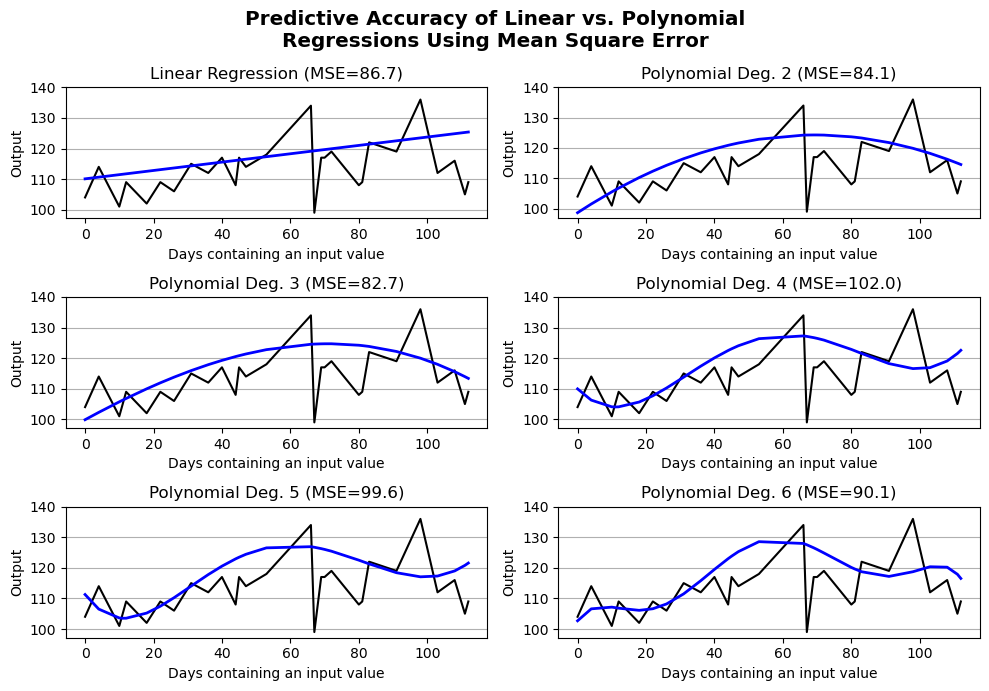

In [102]:
# Now fit to n-degree polynomials
degrees = list(range(2,7)) #list(range(2, 11)) + [15]
#degrees = [2, 5, 6, 7, 8] # any degree > 6 seems to overfit ("eyeball" method)

# Plot outputs:
# Set shape of plots
ncols = 2
nrows = (len(degrees)+1) // ncols + (len(degrees)+1) % 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 7), 
    tight_layout=True) # sharey=True, 

# Set suptitle
fig.suptitle("Predictive Accuracy of Linear vs. Polynomial\n" + \
             "Regressions Using Mean Square Error", 
             size="x-large", weight="bold", wrap=True)
         
# Set x- and y-axis data common to linear and polynomial plots
xlabel = "Days containing an input value"
ylabel = "Output"
y_axis_grid = 'y'
y_ticks = np.arange(100, 145, 10)

# Plot linear regression
axes[0][0].plot(X_test_sorted, y_test_sorted, color="black")
axes[0][0].plot(X_test_sorted, y_pred_lin_sorted, color="blue", linewidth=2)
axes[0][0].set_title(f"Linear Regression (MSE={mse_lin[1]:2.1f})")
axes[0][0].set_xlabel(xlabel)
axes[0][0].set_ylabel(ylabel)
axes[0][0].set_yticks(y_ticks)
axes[0][0].grid(axis = y_axis_grid)

# Plot polynomial regressions
for i in range(len(degrees)):
    dg = degrees[i]
    model_poly = Pipeline([('poly', PolynomialFeatures(degree=dg)),
    ('linear', LinearRegression())]) # fit_intercept=False
    model_poly.fit(X_train_sorted.reshape(-1, 1), y_train_sorted.reshape(-1, 1))
    
    # Make predictions for polynomial regression using the testing set
    y_pred_poly_sorted = model_poly.predict(X_test_sorted.reshape(-1, 1))

    # Coefficients for mean squared error, polynomial regression:
    mse_poly = ([degrees, mean_squared_error(y_test_sorted, y_pred_poly_sorted)])
    
    ax_row, ax_col = (i+1)//ncols, (i+1)%ncols
    ax_xy = axes[ax_row][ax_col]
    ax_xy.plot(X_test_sorted, y_test_sorted, color="black")
    ax_xy.plot(X_test_sorted, y_pred_poly_sorted, color="blue", linewidth=2)
    ax_xy.set_title ("Polynomial Deg. " + str(dg) + f" (MSE={mse_poly[1]:2.1f})")
    ax_xy.set_xlabel(xlabel)
    ax_xy.set_ylabel(ylabel)
    ax_xy.set_yticks(y_ticks)
    ax_xy.grid(axis = y_axis_grid)
    
plt.show()

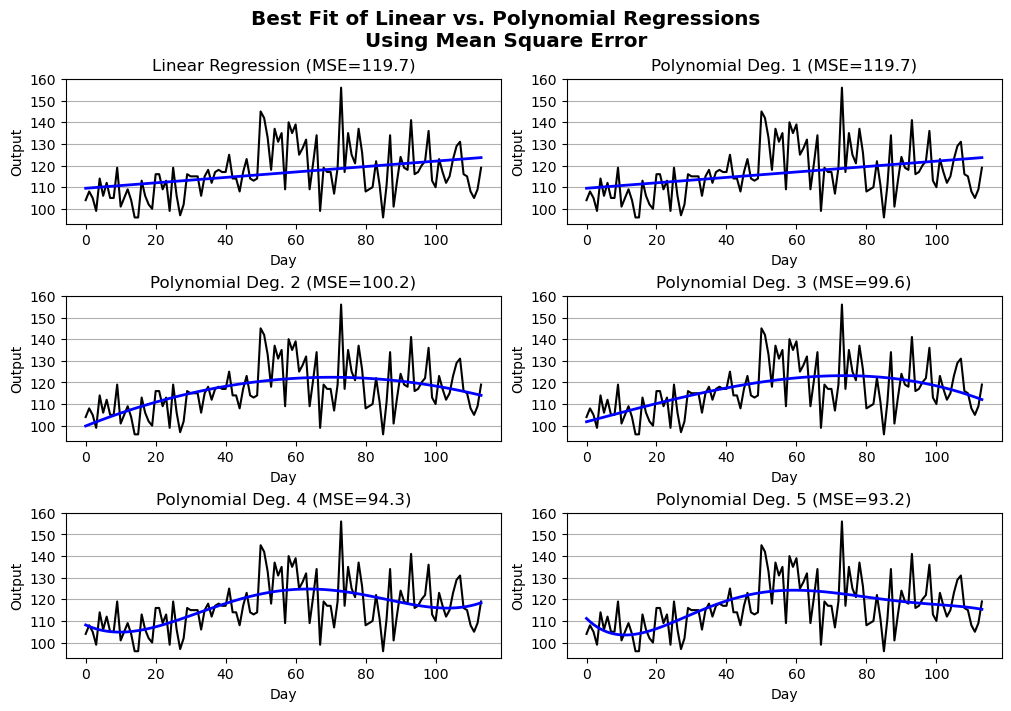

In [103]:
# Create linear, polynomial regression models on entire dataset
regr_all = LinearRegression()

# Train the linear model
X_all_sorted, y_all_sorted = sort_X_and_y(X, y)
regr_all.fit(X_all_sorted.reshape(-1, 1), y_all_sorted.reshape(-1, 1))

# Make predictions for linear regression using the testing set
y_pred_all_sorted = regr_all.predict(X_all_sorted.reshape(-1, 1))

# Coefficients for mean squared error. linear regression:
mse_lin_all = [1, mean_squared_error(y_all_sorted, y_pred_all_sorted)]

degrees_all = [1, 2, 3, 4, 5] #list(range(2, 11)) + [15]
mse_all = []

# Plot outputs:

# Set shape of plots
ncols_all = 2
nrows_all = (len(degrees_all)+1) // ncols_all + (len(degrees_all)+1) % 2

fig, axes = plt.subplots(nrows=nrows_all, ncols=ncols_all, figsize=(10, 7),
    constrained_layout=True)

# Set title
fig.suptitle("Best Fit of Linear vs. Polynomial Regressions\n" + \
    "Using Mean Square Error", size="x-large", weight="bold", wrap=True)
         
# Set x- and y-axis data common to linear and polynomial plots
xlabel = "Day"
ylabel = "Output"
y_axis_grid = 'y'
y_ticks = np.arange(100, 170, 10)

# Plot linear regression
axes[0][0].plot(X_all_sorted, y_all_sorted, color="black")
axes[0][0].plot(X_all_sorted, y_pred_all_sorted, color="blue", linewidth=2)
axes[0][0].set_title(f"Linear Regression (MSE={mse_lin_all[1]:2.1f})")
axes[0][0].set_xlabel(xlabel)
axes[0][0].set_ylabel(ylabel)
axes[0][0].set_yticks(y_ticks)
axes[0][0].grid(axis = y_axis_grid)

# Plot polynomial regressions
for dg in degrees_all:
    model_poly = Pipeline([('poly', PolynomialFeatures(degree=dg)),
    ('linear', LinearRegression())]) # fit_intercept=False
    model_poly.fit(X_all_sorted.reshape(-1, 1), y_all_sorted.reshape(-1, 1))
    
    # Make predictions for polynomial regression using the testing set
    y_pred_poly_sorted_all = model_poly.predict(X_all_sorted.reshape(-1, 1))

    # Coefficients for mean squared error, polynomial regression:
    mse_poly = ([degrees, mean_squared_error(y_all_sorted, y_pred_poly_sorted_all)])
    
    ax_col, ax_row = (dg)%2, (dg)//2

    ax_xy = axes[ax_row][ax_col]
    ax_xy.plot(X_all_sorted, y_all_sorted, color="black")
    ax_xy.plot(X_all_sorted, y_pred_poly_sorted_all, color="blue", linewidth=2)
    ax_xy.set_title ("Polynomial Deg. " + str(dg) + f" (MSE={mse_poly[1]:2.1f})")
    ax_xy.set_xlabel(xlabel)
    ax_xy.set_ylabel(ylabel)
    ax_xy.set_yticks(y_ticks)
    ax_xy.grid(axis = y_axis_grid)
    
plt.show()

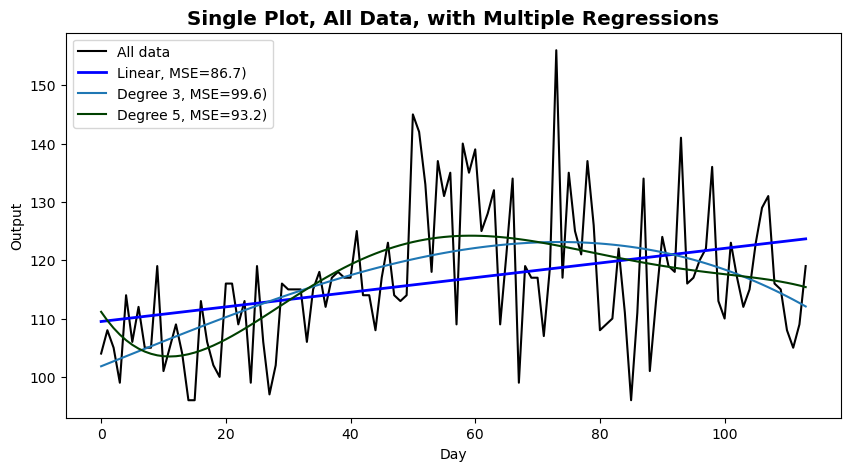

In [104]:
# Plot the regressions on all the data, using a single figure.
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html

deg5color = "#004000" #"#275564"
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Single Plot, All Data, with Multiple Regressions',
    size="x-large", weight="bold")
ax.set_xlabel('Day')
ax.set_ylabel('Output')
ax.plot(X_all_sorted, y_all_sorted, color="k", label="All data")
ax.plot(X_all_sorted, y_pred_all_sorted, color="b", 
    linewidth=2, label=f"Linear, MSE={mse_lin[1]:2.1f})")

# Plot polynomial regressions
degrees_all = [3, 5] # gets too busy if more lines are added
for dg in degrees_all:
    model_poly = Pipeline([('poly', PolynomialFeatures(degree=dg)),
    ('linear', LinearRegression())]) # fit_intercept=False
    model_poly.fit(X_all_sorted.reshape(-1, 1), y_all_sorted.reshape(-1, 1))
    
    # Make predictions for each polynomial regression using the entire set
    y_pred_poly_sorted_all = model_poly.predict(X_all_sorted.reshape(-1, 1))

    # Coefficients for mean squared error, polynomial regression:
    mse_poly = ([degrees, mean_squared_error(y_all_sorted, y_pred_poly_sorted_all)])   
    if dg == 5:
        ax.plot(X_all_sorted, y_pred_poly_sorted_all, color=deg5color,
        label=f"Degree {dg}, MSE={mse_poly[1]:2.1f})")
    else:
        ax.plot(X_all_sorted, y_pred_poly_sorted_all,
        label=f"Degree {dg}, MSE={mse_poly[1]:2.1f})")

plt.legend(loc='upper left')
plt.show()